In [1]:
import jax.numpy as jnp
import numpy.random as npr
from jax import jit, grad, vmap
from jax.example_libraries.optimizers import adam
from jax import value_and_grad
from functools import partial
from jax import jacfwd, jacrev
import jax.nn as jnn
import math
from jax import random
import jax
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from flax import linen as nn
import sklearn.metrics

import argparse
import os
import time
from termcolor import colored
from scipy.io import loadmat
import scipy.io as io
import pickle

import sys
sys.path.append("../..")

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 9})
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")

import warnings
warnings.filterwarnings("ignore")

# Check where gpu is enable or not
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [2]:
cluster = False
save = False
load_flag = True

In [3]:
if cluster == True:
    parser = argparse.ArgumentParser()
    parser.add_argument('-seed', dest='seed', type=int, default=0, help='Seed number.')
    args = parser.parse_args()

    # Print all the arguments
    for arg in vars(args):
        print(f'{arg}: {getattr(args, arg)}')

    seed = args.seed

if cluster == False:
    seed = 0 # Seed number.

if save == True:
    resultdir = os.path.join(os.getcwd(), 'Results')
    if not os.path.exists(resultdir):
        os.makedirs(resultdir)
if load_flag ==True:
    resultdir = os.path.join(os.getcwd(), 'Results')

if save == True and cluster == True:
    orig_stdout = sys.stdout
    q = open(os.path.join(resultdir, 'outputs.txt'), 'w')
    sys.stdout = q
    print ("------START------")

print('seed = '+str(seed))

seed = 0


In [4]:
np.random.seed(seed)
key = 1234 #random.PRNGKey(seed)

In [5]:
# Load the data
data = loadmat('../data/multiparameter/data_022_070_AC_chebfun_more_new_aligned_healing_shorter2.mat') # Load the .mat file
# print(data)
print(data['Utrain_branch'].shape) # Inputs to branch in training
print(data['Utest_branch'].shape) # Inputs to branch in testing
print(data['Vtest_out'].shape) # Output for test samples
print(data['Ytrain_trunk'].shape) # Output for test samples

# Convert NumPy arrays to PyTorch tensors
inputs_train = jnp.array(data['Utrain_branch']).T
outputs_train = jnp.array(data['Vtrain_out']).T
inputs_test = jnp.array(data['Utest_branch']).T
outputs_test = jnp.array(data['Vtest_out']).T
grid = jnp.array(data['Ytrain_trunk'])
#print("grid:", grid)

# Check the shapes of the subsets
print("Shape of inputs_train:", inputs_train.shape)
print("Shape of inputs_test:", inputs_test.shape)
print("Shape of outputs_train:", outputs_train.shape)
print("Shape of outputs_test:", outputs_test.shape)
print("Shape of grid:", grid.shape)
print('#'*100)

(101, 22259)
(101, 5565)
(100, 5565)
(100, 1)
Shape of inputs_train: (22259, 101)
Shape of inputs_test: (5565, 101)
Shape of outputs_train: (22259, 100)
Shape of outputs_test: (5565, 100)
Shape of grid: (100, 1)
####################################################################################################


In [6]:
# Initialize the Glorot (Xavier) normal distribution for weight initialization
initializer = jax.nn.initializers.glorot_normal()

def init_glorot_params(layer_sizes, key = random.PRNGKey(seed)):
    """
    Initialize the parameters of the neural network using Glorot (Xavier) initialization.

    Args:
    layer_sizes (list): List of integers representing the size of each layer.
    key (PRNGKey): Random number generator key for reproducibility.

    Returns:
    list: List of tuples, each containing weights and biases for a layer.
    """
    return [(initializer(key, (m, n), jnp.float32), jnp.zeros(n))
            for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

def BranchNet(params, x):
    """
    Implement the branch network of the DeepONet.

    Args:
    params (list): List of weight and bias tuples for each layer.
    x (array): Input to the branch network.

    Returns:
    array: Output of the branch network.
    """
    def single_forward(params, x):
        for w, b in params:
            outputs = jnp.dot(x, w) + b
            x = jnn.silu(outputs)
        return outputs

    return vmap(partial(single_forward, params))(x)

def TrunkNet(params, x):
    """
    Implement the trunk network of the DeepONet.

    Args:
    params (list): List of weight and bias tuples for each layer.
    x (float): First input to the trunk network.
    t (float): Second input to the trunk network.

    Returns:
    array: Output of the trunk network.
    """
    inputs = jnp.array(x)
    for w, b in params:
        outputs = jnp.dot(x, w) + b
        x = jnn.silu(outputs)
    return outputs

@jit
def DeepONet(params, branch_inputs, trunk_inputs):
    """
    Implement the complete DeepONet architecture.

    Args:
    params (tuple): Tuple containing branch and trunk network parameters.
    branch_inputs (array): Inputs for the branch network.
    trunk_inputs (array): Inputs for the trunk network.

    Returns:
    array: Output of the DeepONet.
    """
    params_branch, params_trunk = params
    branch_outputs = lambda x: BranchNet(params_branch, x)
    b_out = branch_outputs(branch_inputs)
    trunk_output = lambda y: TrunkNet(params_trunk, y)
    t_out = trunk_output(trunk_inputs)
    results = jnp.einsum('ik, lk -> il',b_out, t_out)
    return results

# network parameters.
p = 300 # Number of output neuDONs in both the branch and trunk net outputs.
nx = 101
input_neuDONs_branch = nx # m
input_neuDONs_trunk = 1

layer_sizes_b = [input_neuDONs_branch] + [100]*6 + [p]
layer_sizes_t = [input_neuDONs_trunk] + [100]*6 + [p]

params_branch = init_glorot_params(layer_sizes=layer_sizes_b)
params_trunk = init_glorot_params(layer_sizes=layer_sizes_t)

params= (params_branch, params_trunk)

def objective(params, branch_inputs, trunk_inputs, target_values):
    """
    Define the objective function (loss function) for training.

    Args:
    params (tuple): Tuple containing branch and trunk network parameters.
    branch_inputs (array): Inputs for the branch network.
    trunk_inputs (array): Inputs for the trunk network.
    target_values (array): True output values to compare against.

    Returns:
    float: Mean squared error loss.
    """
    predictions = DeepONet(params, branch_inputs, trunk_inputs)
    loss_mse = jnp.mean((predictions - target_values)**2)
    return loss_mse


# Adam optimizer
@jit
def resnet_update(params, branch_input, trunk_inputs, target_values, opt_state):
    """
    Compute the gradient for a batch and update the parameters.

    Args:
    params (tuple): Current network parameters.
    branch_inputs (array): Inputs for the branch network.
    trunk_inputs (array): Inputs for the trunk network.
    target_values (array): True output values.
    opt_state: Current state of the optimizer.

    Returns:
    tuple: Updated parameters, updated optimizer state, and current loss value.
    """
    value, grads = value_and_grad(objective)(params, branch_input, trunk_inputs, target_values)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Initialize the Adam optimizer
#opt_init, opt_update, get_params = adam(step_size=1e-3, b1=0.9, b2=0.999, eps=1e-08)
#opt_state = opt_init(params)

#bs = 3000 #batch size
#iteration_list, loss_list, test_loss_list = [], [], []
#iteration = 0

#n_epochs = 1
num_samples = len(inputs_train)

# test input preparation
#branch_inputs_test = inputs_test
#targets = outputs_test

In [7]:
def save_model_params(params, resultdir, filename='model_params.pkl'):
    if not os.path.exists(resultdir):
        os.makedirs(resultdir)

    save_path = os.path.join(resultdir, filename)
    with open(save_path, 'wb') as f:
        pickle.dump(params, f)

def load_model_params(resultdir, filename='model_params.pkl'):
    load_path = os.path.join(resultdir, filename)
    with open(load_path, 'rb') as f:
        params = pickle.load(f)
    return params

# Saving
if save:
    save_model_params(params, resultdir)

# Loading (uncomment when needed)
#model_params = load_model_params(resultdir)

Loaded best model parameters
TEST SAMPLE 1
Rel. L2 Error = 0.0029, R2 score = 1.0
######################################################################################################################################################################################################################################
TEST SAMPLE 1001
Rel. L2 Error = 0.0006, R2 score = 0.9999
######################################################################################################################################################################################################################################
TEST SAMPLE 2001
Rel. L2 Error = 0.0004, R2 score = 1.0
######################################################################################################################################################################################################################################
TEST SAMPLE 3001
Rel. L2 Error = 0.0012, R2 score = 1.0
######################################################

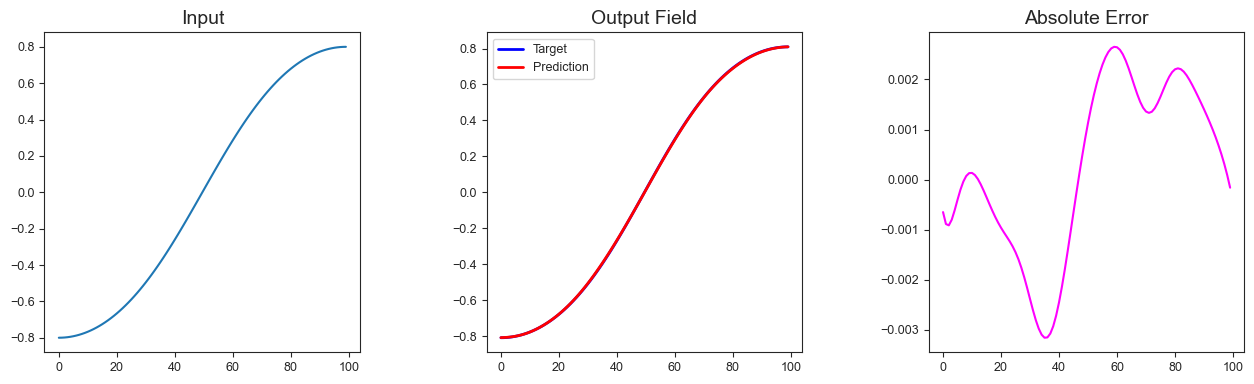

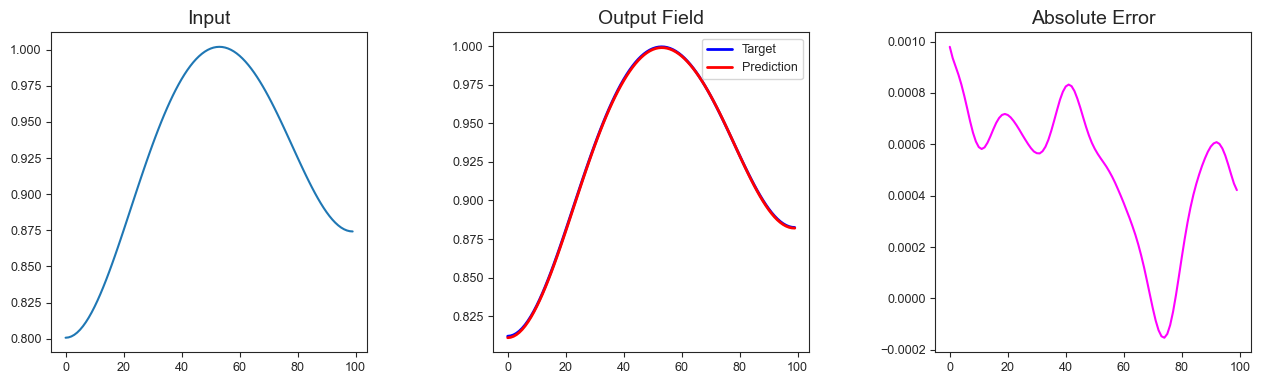

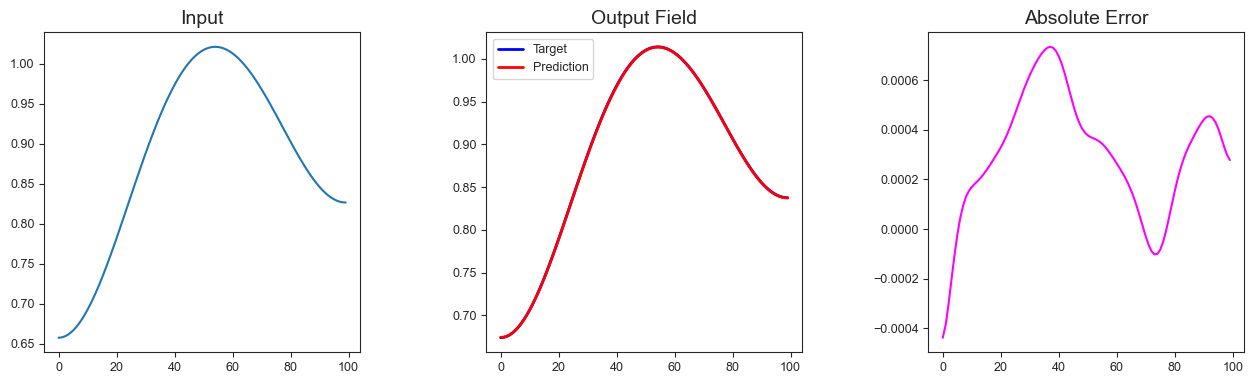

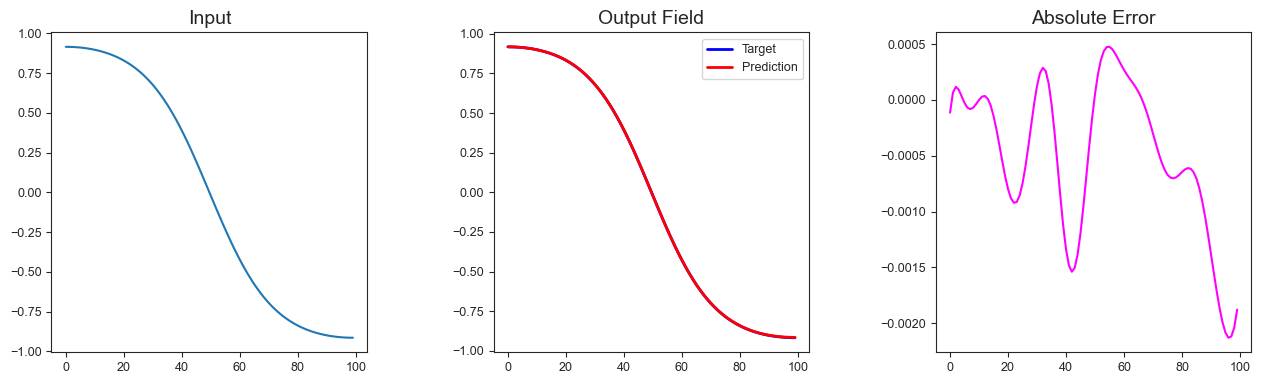

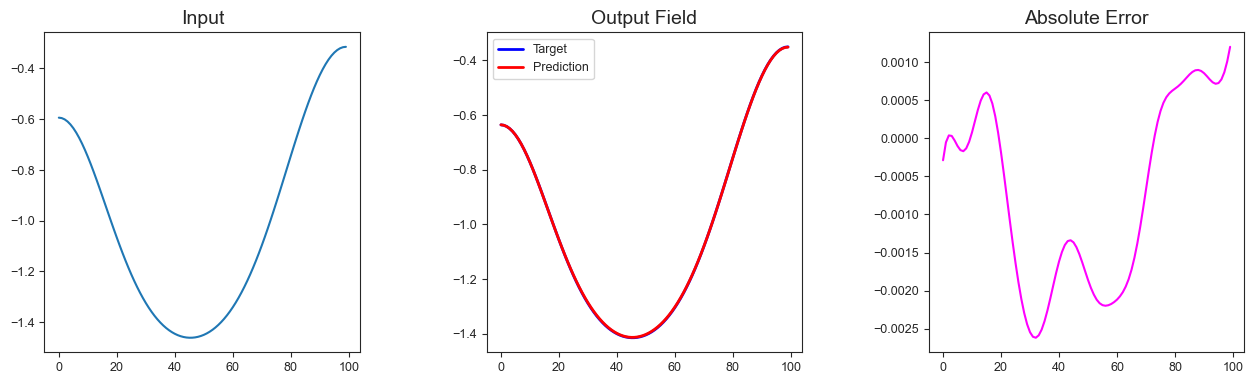

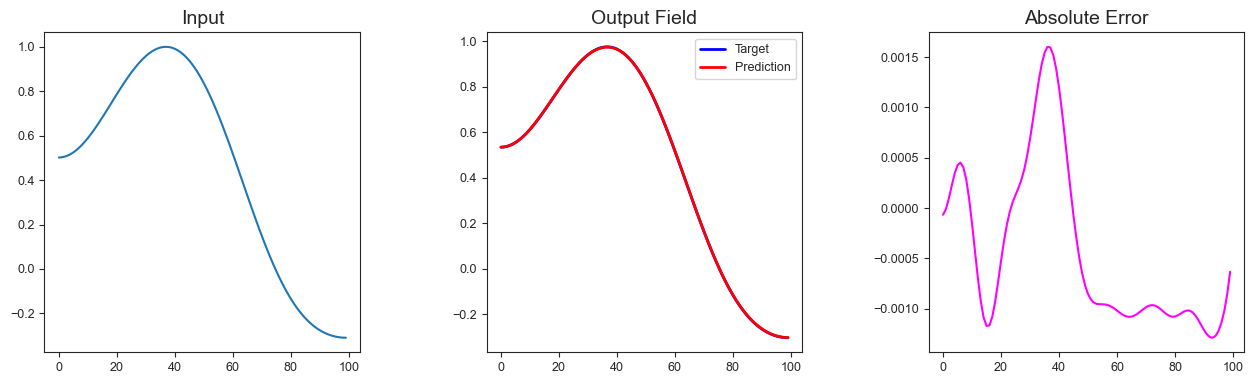

In [8]:
# params_branch, params_trunk = params
# Load the best model parameters
best_params = load_model_params(resultdir, filename='model_params_best.pkl')
print("Loaded best model parameters")

# Predictions
mse_list = []

branch_inputs = inputs_test
trunk_inputs = grid
prediction = DeepONet(best_params, branch_inputs, trunk_inputs) # (bs, neval) 

save_dict = {'u_test': inputs_test.T, 'v_pred': prediction.T,\
             'v_target': outputs_test.T}

io.savemat(resultdir+'/pred.mat', save_dict)

for i in range(inputs_test.shape[0]):

    branch_inputs = inputs_test[i].reshape(1, nx) 
    trunk_inputs = grid # (neval, 1) 

    prediction_i = DeepONet(best_params, branch_inputs, trunk_inputs) # (bs, neval)
    target_i = outputs_test[i]

    mse_i = np.mean((prediction_i - target_i)**2)
    mse_list.append(mse_i.item())

    if i % 1000 == 0:
        print(colored('TEST SAMPLE '+str(i+1), 'red'))

        r2score = metrics.r2_score(target_i.flatten(), prediction_i.flatten())
        relerror = np.linalg.norm(target_i- prediction_i) / np.linalg.norm(target_i)
        r2score = float('%.4f'%r2score)
        relerror = float('%.4f'%relerror)
        print('Rel. L2 Error = '+str(relerror)+', R2 score = '+str(r2score))

        fig = plt.figure(figsize=(15, 4))

        # Adjust subplot parameters for better spacing
        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)

        # Input plot
        ax = fig.add_subplot(1, 3, 1)
        plt.plot(inputs_test[i,0:-1])
        plt.title('Input', fontsize=14)

        # Output plot
        ax = fig.add_subplot(1, 3, 2)
        target = target_i.reshape(grid.shape[0])
        prediction = prediction_i.reshape(grid.shape[0])
        plt.plot(target, color='blue', linewidth=2)
        plt.plot(prediction, color='red', linewidth=2)
        plt.title('Output Field', fontsize=14)
        plt.legend(['Target', 'Prediction'])

        # Error plot
        ax = fig.add_subplot(1, 3, 3)
        error = target - prediction
        plt.plot(error, color='magenta')
        #plt.yscale("log")  
        plt.title('Absolute Error', fontsize=14)

        print(colored('#'*230, 'green'))

mse = sum(mse_list) / len(mse_list)
print("Mean Squared Error Test :\n", mse)

In [9]:
def eval_deepONet(params, ff, yy, simmetry, flag_single):
    ffs=ff.shape
    if len(ffs)==1:
        ff=ff.reshape(1,-1)
    yy=(yy.flatten()).reshape(-1,1)
    
    if simmetry == 1:
        if flag_single == 0:
            # Evaluate with symmetry
            ff_rev = jnp.hstack([-ff[:, :-1], ff[:, -1:]])
            G = (DeepONet(params,ff, yy) - DeepONet(params,ff_rev, yy)) / 2
        else:
            # Evaluate with symmetry, single flag: only take part of the input
            G = (DeepONet(params,ff, yy) - DeepONet(params,-ff, yy)) / 2
    else:
        if flag_single == 0:
            # Direct evaluation without symmetry
            G = DeepONet(params,ff, yy)
        else:
            # Single flag evaluation, only part of the input
            G = DeepONet_model(params,ff, yy)
    #if ff.shape[0]==1:
    #    nx=G.shape[1]
    #    #print('size G ', G.shape)
    #    #print('size ff ', ff.shape)
    #    ffr=ff[0,:nx].reshape(1,-1)
    #    #print('size ffr ', ffr.shape)
    #    df=G-ffr
    #    errn=np.linalg.norm(df)
    #    tol=0.1
    #    scale=np.min([1,np.sqrt(errn/tol)])
    #    #print(scale)
    #    #
    #    G=ffr+scale*df
    if len(ffs)==1:
        G=G.flatten()
    
    return G

In [97]:
def time_stepper(fun, u0, Nt):
    """
    Time stepping function that iteratively applies a function to evolve the system.

    Parameters:
    fun : function
        The function that defines the evolution of the system at each time step.
    u0 : array-like
        Initial condition for the system (should be a 1D array).
    Nt : int
        The number of time steps to perform.

    Returns:
    uuend : ndarray
        The final value of the system after all time steps.
    """
    uu = np.zeros((Nt,u0.size))  # Initialize the solution array
    uu[0] = u0.flatten()  # Set the initial condition

    for i in range(1, Nt):
        uu[i] = fun(uu[i - 1])  # Apply the function to update the state

        # FD corrections of the boundary conditions (optional)
        uu[i,0] = (4 * uu[i,1] - uu[i,2]) / 3
        uu[i,-1] = (4 * uu[i,-2] - uu[i,-3]) / 3

        # You can also use weighted correction for boundaries
        #uu[i, 0] = uu[i, 0] * 0.9 + (4 * uu[i, 1] - uu[i, 2]) / 3 * 0.1
        #uu[i, -1] = uu[i, -1] * 0.9 + (4 * uu[i, -2] - uu[i, -3]) / 3 * 0.1

    uuend = uu[-1]  # Get the final state at the last time step
    return uuend

In [98]:
# Allen-Cahn PDE infos
x0=-1;
xf=1;
t0=0;

#
# DeepONet
Nx=100; #grid of RandONet
dt=0.01; #time step of the RandONet
xspan=np.linspace(x0, xf, Nx); #output grid
#xspan = xspan.reshape(1, -1)
# Reshape it into (100, 1)
yspan = xspan.reshape(-1, 1)
simmetry=1;
flag_single=0; #0 is for multi-parameter, 1 for single_parameter
# Define DeepONet function
fun_DON = lambda x, ep: eval_deepONet(best_params, np.concatenate((x, ep)), yspan, simmetry, flag_single)

# Define equation using time_stepper
eqs_DON = lambda x, ep: (x - time_stepper(lambda x: fun_DON(x, ep), x, 2))

In [99]:
def AC_FD_forwardEuler(u0, epsilon, dx, dt):
    # Second derivative approximation (u_xx)
    u_xx = (u0[:-2] - 2 * u0[1:-1] + u0[2:]) / dx**2
    #u_xx = u_xx.reshape(1,-1)
    
    # Interior points of u0
    u0int = u0[1:-1]#.reshape(1,-1)
    
    # Boundary corrections
    ul = (4 * u0int[0] - u0int[1]) / 3
    ur = (4 * u0int[-1] - u0int[-2]) / 3

    # Right-hand side of the equation
    rhs0 = epsilon * u_xx + (1 / epsilon) * (u0int - u0int**3)
    
    # Update interior points
    u1int = u0int + dt * rhs0

    #ul=ul.reshape(1,-1)
    #ur=ur.reshape(1,-1)
    # Reconstruct the full solution, including boundary corrections
    u1 = np.concatenate(([ul], u1int, [ur]))
    
    return u1

In [100]:
# FD
NxFD = 401  # grid for Finite difference
xspanFD = np.linspace(x0, xf, NxFD) # grid in Python (replace linspace)
#xspanFD= xspanFD.reshape(1,-1)  
# Reshape it into (100, 1)
yspanFD = xspanFD.reshape(-1, 1)
dxFD = xspanFD[1] - xspanFD[0]  # grid spacing
dtFD = dxFD**2 / 2 / 0.7 / 2  # time step

# Define the function for the Finite Difference forward Euler method
fun_FD = lambda x, ep: AC_FD_forwardEuler(x, ep, dxFD, dtFD)

# Define the equation using time_stepper with a lambda function
eqsFD = lambda x, ep: x - time_stepper(lambda x: fun_FD(x, ep), x, min(round(dt / dtFD) + 1, 100))


In [121]:
# First branch sin n=1
# Branch 1
ep0 = 0.22 #0.22
ep0 = np.array([ep0])
#ep0 = ep0.reshape(-1, 1)
# Initial condition
nn = 1
epss_bif_sin = 1 / (np.pi / 2 + (nn - 1) * np.pi)
ep_final = epss_bif_sin * 1.02
sb = 1.2 * np.sqrt(abs(ep0 - epss_bif_sin))
sb = sb * (1 + (2 * np.random.rand() - 1) / 100)

# Define u0 as a function of x
def u0_f(x):
    return sb * np.sin(((nn - 1) * np.pi + np.pi / 2) * x)

# Apply to the grid (xspan, xspanFD)
u0DON = u0_f(xspan)
print('u0DON shape: ',u0DON.shape)
#print('e0 shape: ',ep0.shape)
print('ueDON shape: ', (np.concatenate((u0DON,ep0))).shape)
u1DON=fun_DON(u0DON,ep0)
print('u1DON shape: ',u1DON.shape)
u0FD = u0_f(xspanFD)
print('u0FD shape: ',u0FD.shape)
print('ueFD shape: ', (np.concatenate((u0FD,ep0))).shape)
u1FD=fun_FD(u0FD,ep0)
print('u1FD shape: ',u1FD.shape)


# Increment value for epsilon
d_ep = 0.005

u0DON shape:  (100,)
ueDON shape:  (101,)
u1DON shape:  (100,)
u0FD shape:  (401,)
ueFD shape:  (402,)
u1FD shape:  (401,)


u00DON shape:  (100,)
u00FD shape:  (401,)
xspanDON shape:  (100,)
xspanFD shape:  (401,)


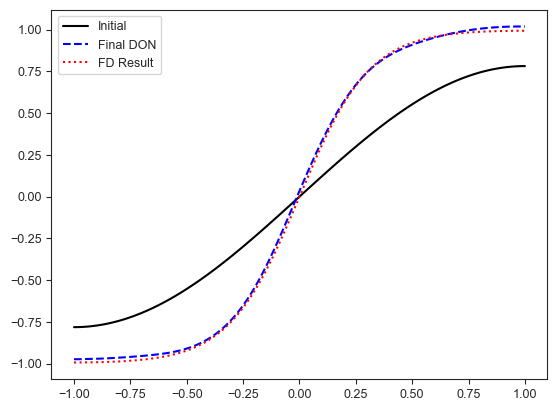

100

In [134]:
# Bifurcation part
Nt = 101  # 41; 31;
Ntfd=101
u00DON = time_stepper(lambda x: fun_DON(x, ep0), u0DON, Nt)
u00FD = time_stepper(lambda x: fun_FD(x, ep0), u0FD, round((Ntfd-1) * dt / dtFD) + 1)
print('u00DON shape: ',u00DON.shape)
print('u00FD shape: ',u00FD.shape)
print('xspanDON shape: ',xspan.shape)
print('xspanFD shape: ',xspanFD.shape)

# Plot results
plt.figure(1)
plt.clf()  # Clear figure to start fresh

# Plot initial and final results
plt.plot(xspan, u0DON, 'k-', label='Initial')
plt.plot(xspan, u00DON, 'b--', label='Final DON')
plt.plot(xspanFD, u00FD, 'r:', label='FD Result')

plt.legend()
plt.pause(0.001)  # Small pause to simulate MATLAB's pause (for interactive plotting)

# Show plot
plt.show()
u00DON.size

In [135]:
from scipy.optimize import fsolve, newton_krylov
from scipy.optimize import NoConvergence

In [145]:
def arc_length_cont_JFNKgmres(fun, x0, lam0, d_lam, lamfinal=np.inf, maxiters=100, xtol=1e-14, ftol=1e-12, epFD=1e-8, maxiterNew=100):
    lam00=lam0
    lam1 = lam0 + d_lam
    np_ = x0.size
    xtolJFNKgmres = [xtol, xtol * 100]
    parms = [maxiters, maxiterNew, 0.9, 2, 20]
    #print('norm x0_init: ', np.linalg.norm(fun(x0,lam0)))
    if maxiterNew==None:
        maxfev=0
    else:
        maxfev=maxiterNew*(np_+1)
    # Solving initial guess using fsolve (equivalent to newton_method in MATLAB)
    try:
        x00 = newton_krylov(lambda x: fun(x, lam0), x0, x_tol=xtolJFNKgmres[0], maxiter=maxiterNew, rdiff=epFD)
    except NoConvergence as e:
        print("Newton-Krylov did not converge. Switching to fsolve.")
        x00 = fsolve(lambda x: fun(x, lam0), x0, xtol=xtol, maxfev=maxfev, epsfcn=epFD)
    #print('norm x00_newton: ', np.linalg.norm(fun(x00,lam0)))
    #x00 = newton_krylov(lambda x: fun(x, lam0), x00, x_tol=xtol, maxiter=maxiterNew)
    #print('norm x00_NK: ', np.linalg.norm(fun(x00,lam0)))
    save_x = np.zeros((maxiters,np_))
    save_x[0,:] = x00
    save_lam = np.zeros(maxiters)
    save_lam[0] = lam0
    
    # Solve for the next step using newton_krylov (equivalent to nsoli in MATLAB)
    #print('norm x11_init: ', np.linalg.norm(fun(x00,lam1)))
    try:
        x11 = newton_krylov(lambda x: fun(x, lam1), x00, x_tol=xtolJFNKgmres[0], maxiter=maxiterNew, rdiff=epFD)
        #print("Converged solution:", result)
    #except Exception as e:
    except NoConvergence as e:
        print("Newton-Krylov did not converge. Switching to fsolve.")
        x11 = fsolve(lambda x: fun(x, lam1), x00, xtol=xtol, maxfev=maxfev, epsfcn=epFD)
        #result = x11  # Fallback to initial guess or other alternative
    #print('norm x11_NK: ', np.linalg.norm(fun(x11,lam1)))
    save_x[1,:] = x11
    print(save_x.shape)
    save_lam[1] = lam1
    # Initializing delta values
    dx = x11 - x00
    lam = 2 * lam1 - lam0
    ds = np.sqrt(np.sum(dx ** 2) + d_lam ** 2)
    k = 2
    
    # Additional condition to control the arc length
    x = 2 * x11 - x00
    
    while lam > lam00 and k < (maxiters) and lam < lamfinal: #and x[0] < 0:
        k += 1
        x = 2 * x11 - x00
        #x = x*0.99
        lam = 2 * lam1 - lam0
        alpha = (x11 - x00) / ds
        bhta = (lam1 - lam0) / ds
        
        # Arc-length condition function
        Nfun = lambda xt, lamt: np.dot(alpha, (xt - x11)) + np.dot(bhta, (lamt - lam1)) - ds #arclength condition
        augfun = lambda xlam: np.concatenate([fun(xlam[:-1], xlam[-1:]), [Nfun(xlam[:-1], xlam[-1:])]])
        
        #
        xlam0 = np.concatenate((x, lam))
        #print('norm x',k,k,'_init: ', np.linalg.norm(fun(x,lam)))
        # Apply Newton method for full arc-length solving (using fsolve or newton_krylov)
        try:
            xlam = newton_krylov(augfun, xlam0, x_tol=xtolJFNKgmres[0], x_rtol=xtolJFNKgmres[1], maxiter=maxiterNew, rdiff=epFD)
        except NoConvergence as e:
            print("Newton-Krylov did not converge. Switching to fsolve.")
            xlam = fsolve(augfun, xlam0, xtol=xtol, maxfev=maxfev, epsfcn=epFD)

        x = xlam[:-1]
        lam = xlam[-1:]
        
        #print('norm x',k,k,'_NK: ', np.linalg.norm(fun(x,lam)))
        # Store the results
        save_x[k-1,:] = x
        save_lam[k-1] = lam
        
        lam0 = lam1
        lam1 = lam
        x00 = x11
        x11 = x

        # Output the status
        print(f'ARCLength ---- iter={k}, lambda={lam[0]:2.4e}')
        if lam <= lam00:
            print('lambda came back to first value')
        
        if k >= (maxiters):
            print('all iterations completed')
            
        if lam >= lamfinal:
            print('lambda exceeded the bound')
            print(lam)
            print(lamfinal)

    return save_x[:k, :], save_lam[:k]

DeepONet
ep0  [0.22] ep final  0.649352167814933
(400, 100)
ARCLength ---- iter=3, lambda=2.2503e-01
ARCLength ---- iter=4, lambda=2.2759e-01
ARCLength ---- iter=5, lambda=2.3019e-01
ARCLength ---- iter=6, lambda=2.3283e-01
ARCLength ---- iter=7, lambda=2.3551e-01
ARCLength ---- iter=8, lambda=2.3823e-01
ARCLength ---- iter=9, lambda=2.4099e-01
ARCLength ---- iter=10, lambda=2.4381e-01
ARCLength ---- iter=11, lambda=2.4666e-01
ARCLength ---- iter=12, lambda=2.4957e-01
ARCLength ---- iter=13, lambda=2.5252e-01
ARCLength ---- iter=14, lambda=2.5553e-01
ARCLength ---- iter=15, lambda=2.5857e-01
ARCLength ---- iter=16, lambda=2.6166e-01
ARCLength ---- iter=17, lambda=2.6479e-01
ARCLength ---- iter=18, lambda=2.6795e-01
ARCLength ---- iter=19, lambda=2.7115e-01
ARCLength ---- iter=20, lambda=2.7438e-01
ARCLength ---- iter=21, lambda=2.7764e-01
ARCLength ---- iter=22, lambda=2.8091e-01
ARCLength ---- iter=23, lambda=2.8421e-01
ARCLength ---- iter=24, lambda=2.8751e-01
ARCLength ---- iter=25,

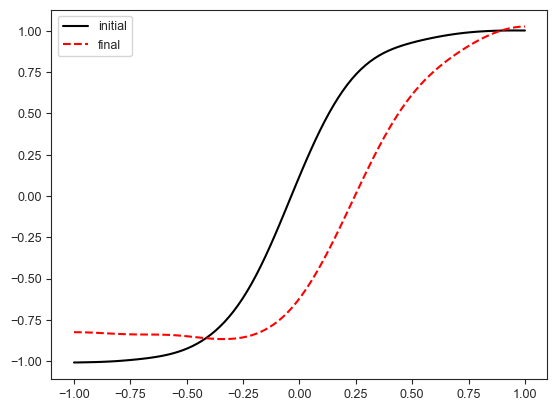

In [147]:
print('DeepONet')
print('ep0 ',ep0, 'ep final ', ep_final)
# Step 4: Effective arc length continuation for DON
save_xDON, save_epDON = arc_length_cont_JFNKgmres(
    eqs_DON, u00DON, ep0, d_ep/2, ep_final, 400, 1e-5, 1e-5, 1e-3, 20
) # maxiters=200, xtol=1e-5, ftol=1e-4, epFD=1e-4, maxiterNew=100

# Plot results
plt.figure(2)
plt.clf()  # Clear figure to start fresh
plt.plot(xspan, save_xDON[0,:], 'k-', label='initial')
plt.plot(xspan, save_xDON[-1,:], 'r--', label='final')

plt.legend()
plt.pause(0.001)

In [148]:
print('#'*100)
print('FD')
save_xFD, save_epFD = arc_length_cont_JFNKgmres(
    eqsFD, u00FD, ep0, d_ep, ep_final, 200, 1e-10, 1e-8, 1e-7, 40
) # maxiters=200, xtol=1e-10, ftol=1e-8, epFD=1e-7, maxiterNew=100

####################################################################################################
FD
(200, 401)
ARCLength ---- iter=3, lambda=2.3005e-01
ARCLength ---- iter=4, lambda=2.3515e-01
ARCLength ---- iter=5, lambda=2.4029e-01
ARCLength ---- iter=6, lambda=2.4547e-01
ARCLength ---- iter=7, lambda=2.5070e-01
ARCLength ---- iter=8, lambda=2.5596e-01
ARCLength ---- iter=9, lambda=2.6126e-01
ARCLength ---- iter=10, lambda=2.6659e-01
ARCLength ---- iter=11, lambda=2.7195e-01
ARCLength ---- iter=12, lambda=2.7734e-01
ARCLength ---- iter=13, lambda=2.8274e-01
ARCLength ---- iter=14, lambda=2.8816e-01
ARCLength ---- iter=15, lambda=2.9360e-01
ARCLength ---- iter=16, lambda=2.9904e-01
ARCLength ---- iter=17, lambda=3.0449e-01
ARCLength ---- iter=18, lambda=3.0993e-01
ARCLength ---- iter=19, lambda=3.1537e-01
ARCLength ---- iter=20, lambda=3.2080e-01
ARCLength ---- iter=21, lambda=3.2622e-01
ARCLength ---- iter=22, lambda=3.3162e-01
ARCLength ---- iter=23, lambda=3.3699e-01
ARCLength 

In [149]:
save1_xDON=save_xDON;
save1_epDON=save_epDON;
save1_xFD=save_xFD;
save1_epFD=save_epFD;
print('shape save1_x DON',save1_xDON.shape)
print('shape save1_x FD',save1_xFD.shape)

shape save1_x DON (193, 100)
shape save1_x FD (200, 401)


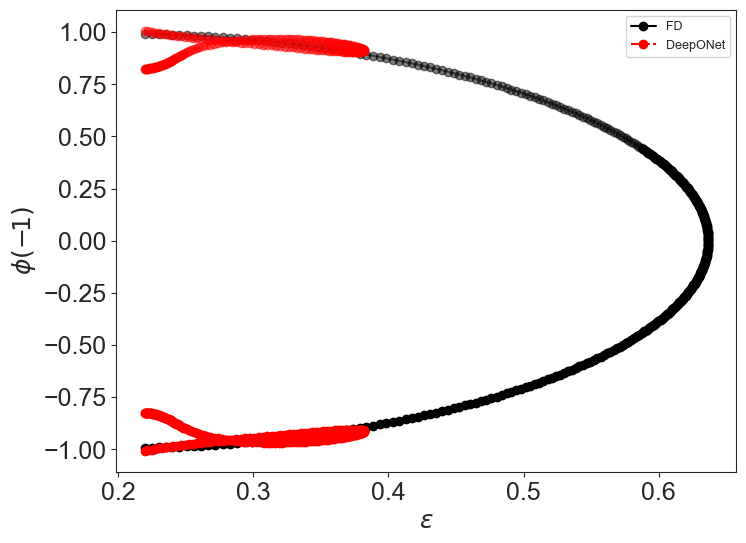

<Figure size 640x480 with 0 Axes>

In [151]:
plt.figure(figsize=(8, 6))

# Plot the first set of data (FD)
plt.plot(save1_epFD, save1_xFD[:, 0].flatten(), 'k-o', label='FD')  # Plot the first row of xFD
plt.plot(save1_epFD, -save1_xFD[:, 0].flatten(), 'k-o', label='_nolegend_', alpha=0.5)  # Negative FD

# Plot the second set of data (RandONet)
plt.plot(save1_epDON, save1_xDON[:,0].flatten(), 'r--o', label='DeepONet')  # Plot the first row of xDON
plt.plot(save1_epDON, -save1_xDON[:,0].flatten(), 'r--o', label='_nolegend_', alpha=0.5)  # Negative RandONet

# Add legend
plt.legend()

# Set axis labels with LaTeX formatting
plt.xlabel(r'$\varepsilon$', fontsize=18)
plt.ylabel(r'$\phi(-\!1)$', fontsize=18)

# Set font size for the axes
plt.tick_params(axis='both', labelsize=18)

# Show the plot
plt.pause(0.001)
plt.savefig('bif_diag_DeepONet.png', dpi=300, bbox_inches='tight')
plt.savefig('bif_diag_DeepONet.pdf', dpi=300, bbox_inches='tight')
plt.savefig('bif_diag_DeepONet.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()